In [1]:
from src.data import save_imgs_list_2npy
import os
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

from torch.utils.data import DataLoader

from src import data, evaluate, model, preprocessing, visualization
from src.lib import utils

In [3]:
#Prueba para generar csv de como deberian salir las images
from os import listdir
from os.path import isfile, join
mypath = 'data/images/mvd_dataset/loaded_images' 
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [4]:
print(len(onlyfiles))

20922


In [5]:
days_list = []
dict_day = {}

for i in range(len(onlyfiles)):
    day = int(onlyfiles[i][8:11]) #dia el anio
    if day not in(days_list):
        days_list.append(day)
    if day in dict_day.keys():
       dict_day[day].append(onlyfiles[i])
    else:
        dict_day[day] = []
        dict_day[day].append(onlyfiles[i])
         
        
print('El dataset de mvd tiene',len(days_list), 'dias')

El dataset de mvd tiene 269 dias


In [10]:
val_days_df = pd.read_csv('reports/val_days.csv',header=None)
val_days = val_days_df.values[0].tolist()

print(type(val_days))
print(len(val_days))

<class 'list'>
40


In [13]:
# import shutil, os
# mypath = 'data/images/mvd_dataset/loaded_images/' 
# for day in val_days:
#     for filename in dict_day[day]:
#         shutil.move( mypath+ filename, 'data/images/mvd_dataset/mvd_val')

In [15]:
mypath = 'data/images/mvd_dataset/loaded_images' 
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(len(onlyfiles))

mypath = 'data/images/mvd_dataset/mvd_val' 
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(len(onlyfiles))

17854
3068


In [3]:
utils.image_sequence_generator(path='data/images/mvd_dataset/mvd_train', 
                               in_channel =3,
                               out_channel = 1,
                               min_time_diff = 5,
                               max_time_diff= 15,
                               csv_path = 'data/images/mvd_dataset/train_sequences.csv')

utils.image_sequence_generator(path='data/images/mvd_dataset/mvd_val', 
                               in_channel =3,
                               out_channel = 1,
                               min_time_diff = 5,
                               max_time_diff= 15,
                               csv_path = 'data/images/mvd_dataset/val_sequences.csv')

In [12]:
print(sorted(dict_day[1]))

['ART_2020001_082021.npy', 'ART_2020001_083021.npy', 'ART_2020001_084021.npy', 'ART_2020001_085021.npy', 'ART_2020001_090021.npy', 'ART_2020001_091021.npy', 'ART_2020001_092021.npy', 'ART_2020001_093021.npy', 'ART_2020001_094021.npy', 'ART_2020001_095021.npy', 'ART_2020001_100021.npy', 'ART_2020001_101021.npy', 'ART_2020001_102021.npy', 'ART_2020001_103021.npy', 'ART_2020001_104021.npy', 'ART_2020001_105021.npy', 'ART_2020001_110021.npy', 'ART_2020001_111021.npy', 'ART_2020001_112021.npy', 'ART_2020001_113021.npy', 'ART_2020001_114021.npy', 'ART_2020001_115021.npy', 'ART_2020001_120021.npy', 'ART_2020001_121021.npy', 'ART_2020001_122021.npy', 'ART_2020001_123021.npy', 'ART_2020001_124021.npy', 'ART_2020001_125021.npy', 'ART_2020001_130021.npy', 'ART_2020001_131021.npy', 'ART_2020001_132021.npy', 'ART_2020001_133021.npy', 'ART_2020001_134021.npy', 'ART_2020001_135021.npy', 'ART_2020001_140021.npy', 'ART_2020001_141021.npy', 'ART_2020001_142021.npy', 'ART_2020001_143021.npy', 'ART_202000

In [50]:
from datetime import datetime
from datetime import timedelta
import csv

in_channel = 3
out_channel = 1

fieldnames = []
for i in range(in_channel+out_channel):
    if i < in_channel:
        fieldnames.append('input'+str(i))
    else:
        fieldnames.append('output'+str(i-in_channel))

dt_5min =timedelta(minutes = 5)
dt_15min =timedelta(minutes = 15)

with open('reports/data_sequences.csv', 'w', encoding='UTF8',newline='') as f:
    writer = csv.writer(f)
    for day in dict_day.keys(): #recorro cada dia por separado
        len_day = len(dict_day[day]) 
        for i in range(len_day - (in_channel+out_channel)): #me fijo si puedo completar un conjunto de datos
            complete_seq = True
            image_sequence = []
            for j in range(in_channel+out_channel-1): #veo si puede rellenar un dato
                if complete_seq:
                    dt_i = datetime(1997,5,28,hour = int(dict_day[day][i+j][12:14]), 
                                    minute = int(dict_day[day][i+j][14:16]), 
                                    second = int(dict_day[day][i+j][16:18]) )
                    dt_f = datetime(1997,5,28,hour = int(dict_day[day][i+j+1][12:14]), 
                                    minute = int(dict_day[day][i+j+1][14:16]), 
                                    second = int(dict_day[day][i+j+1][16:18]) )
                    
                    time_diff = dt_f - dt_i
                    if  dt_5min < time_diff < dt_15min: #las imagenes estan bien espaciadas en el tiempo
                        if j == 0:
                            image_sequence.append(dict_day[day][i+j])
                            image_sequence.append(dict_day[day][i+j+1])
                        if j>0:
                            image_sequence.append(dict_day[day][i+j+1])          
                    else:
                        complete_seq = False
                    
            if complete_seq: 
                writer.writerow(image_sequence)


In [ ]:
from os import listdir
from os.path import isfile, join
from datetime import datetime
from datetime import timedelta
import csv

def image_sequence_generator(path, in_channel,out_channel, min_time_diff, max_time_diff, csv_path):
     #file names
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    
    days_list = []
    dict_day = {}

    for i in range(len(onlyfiles)):
        day = int(onlyfiles[i][8:11]) #dia el anio
        if day not in(days_list):
            days_list.append(day)
        if day in dict_day.keys():
        dict_day[day].append(onlyfiles[i])
        else:
            dict_day[day] = []
            dict_day[day].append(onlyfiles[i])
    
    fieldnames = []
    for i in range(in_channel+out_channel):
        if i < in_channel:
            fieldnames.append('input'+str(i))
        else:
            fieldnames.append('output'+str(i-in_channel))

    dt_min =timedelta(minutes = min_time_diff)
    dt_max =timedelta(minutes = max_time_diff)

    with open(csv_path, 'w', encoding='UTF8',newline='') as f:
        writer = csv.writer(f)
        for day in dict_day.keys(): #recorro cada dia por separado
            len_day = len(dict_day[day]) 
            for i in range(len_day - (in_channel+out_channel)): #me fijo si puedo completar un conjunto de datos
                complete_seq = True
                image_sequence = []
                for j in range(in_channel+out_channel-1): #veo si puede rellenar un dato
                    if complete_seq:
                        dt_i = datetime(1997,5,28,hour = int(dict_day[day][i+j][12:14]), 
                                        minute = int(dict_day[day][i+j][14:16]), 
                                        second = int(dict_day[day][i+j][16:18]) )
                        dt_f = datetime(1997,5,28,hour = int(dict_day[day][i+j+1][12:14]), 
                                        minute = int(dict_day[day][i+j+1][14:16]), 
                                        second = int(dict_day[day][i+j+1][16:18]) )
                        
                        time_diff = dt_f - dt_i
                        if  dt_min < time_diff < dt_max: #las imagenes estan bien espaciadas en el tiempo
                            if j == 0:
                                image_sequence.append(dict_day[day][i+j])
                                image_sequence.append(dict_day[day][i+j+1])
                            if j>0:
                                image_sequence.append(dict_day[day][i+j+1])          
                        else:
                            complete_seq = False
                        
                if complete_seq: 
                    writer.writerow(image_sequence)
            
    

In [109]:
seq_df = pd.read_csv('reports/data_sequences.csv',header=None)

In [119]:
print(seq_df.values[0])
np.random.shuffle(seq_df.values)
print(seq_df.values[0])

['ART_2020321_102015.npy' 'ART_2020321_103015.npy'
 'ART_2020321_104015.npy' 'ART_2020321_105015.npy']
['ART_2020356_133021.npy' 'ART_2020356_134021.npy'
 'ART_2020356_135021.npy' 'ART_2020356_140021.npy']


In [127]:
from torch.utils.data import Dataset
class MontevideoDataset(Dataset):
    def __init__(self, path,path_sequence_csv,in_channel=3 ,out_channel=1 ,shuffle=False):
        super(MontevideoDataset, self).__init__()

        self.path = path
        self.path_sequence_csv = path_sequence_csv
        self.shuffle = shuffle
        self.in_channel = in_channel
        self.out_channel = out_channel
        
        self.sequence_df = pd.read_csv(path_sequence_csv,header=None)
        if shuffle:
            np.random.shuffle(self.sequence_df.values)
        
    def __getitem__(self, index):
                  
        # images loading
        
        for i in range(self.in_channel + self.out_channel):
            if i == 0: #first image in in_frames
                #in_frames = np.load(self.path + self.sequence_df.values[index][i])
                in_frames = np.load(os.path.join(self.path, self.sequence_df.values[index][i]) )
                in_frames = in_frames[np.newaxis]
            if i>0 and i<self.in_channel: #next images in in_frames
                #aux = np.load(self.path+self.sequence_df.values[index][i])
                aux = np.load(os.path.join(self.path, self.sequence_df.values[index][i]) )
                aux = aux[np.newaxis]
                in_frames = np.concatenate((in_frames,aux),axis=0)  
            if i == self.in_channel: #first image in out_frames
                #out_frames = np.load(self.path + self.sequence_df.values[index][i])
                out_frames = np.load(os.path.join(self.path, self.sequence_df.values[index][i]) )
                out_frames = out_frames[np.newaxis]
            if i > in_channel:
                #aux = np.load(self.path+self.sequence_df.values[index][i])
                aux = np.load(os.path.join(self.path, self.sequence_df.values[index][i]) )
                aux = aux[np.newaxis]
                out_frames = np.concatenate((out_frames,aux),axis=0)
            
        return in_frames , out_frames

    def __len__(self):
        return (len(self.sequence_df))

In [131]:
from torch.utils.data import DataLoader

mvd_ds = MontevideoDataset(path = 'data/mvd/mvd_dataset/' , path_sequence_csv = 'reports/data_sequences.csv',
                           in_channel = 3,out_channel=1, shuffle = True)

test_dataloader = DataLoader(mvd_ds, batch_size=64, shuffle=True)

in_frames, out_frames = next(iter(test_dataloader))
print(in_frames.shape)
print(type(in_frames[10]))

print(out_frames.shape)

torch.Size([64, 3, 256, 256])
<class 'torch.Tensor'>
torch.Size([64, 1, 256, 256])


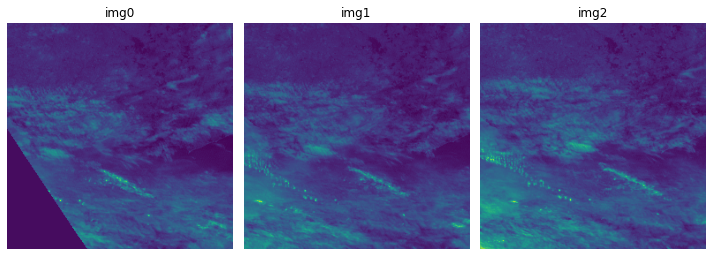

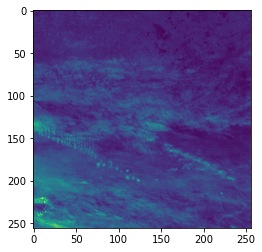

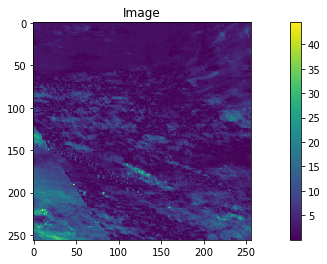

In [125]:
n=18

visualization.show_image_list(in_frames[n],rows =1)
plt.imshow(out_frames[n,0])
plt.show()

visualization.show_images_diff(in_frames[n,0], out_frames[n,0])


In [ ]:
batch_size = 64
transformed_dataset = vaporwaveDataset(ims=X_train)
train_dl = DataLoader(transformed_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [2]:
def main_test(model_instance, dl_sw):
    predict_horizon = 10
    error_list_rmse =[]
    error_list_ssim = []

    per_predict_time= []
    eval_time = []
    cmv_predict_time = []
    
    for idx, samples in enumerate(dl_sw):

        if idx%50 == 0:
           print(idx)
        
        #predict depending on model
        if (isinstance(model_instance, model.Persistence)):
            start = time.time()
            predictions, prediction_ts = model_instance.predict(
                                    samples['images'][1], 
                                    samples['time_stamps'][1], 
                                    predict_horizon)
            end = time.time()
            per_predict_time.append(end-start)
            dynamic_window = False
        elif (isinstance(model_instance, model.Cmv)):
            start = time.time()
            predictions , cmv_ts = model_instance.predict(
                                    imgi=samples['images'][0, :, :], 
                                    imgf=samples['images'][1, :, :],
                                    imgf_ts = samples['time_stamps'][1], 
                                    period=10*60, delta_t=10*60, 
                                    predict_horizon=predict_horizon) 
            end = time.time()
            cmv_predict_time.append(end-start)
            dynamic_window = True

        #evaluate
        start = time.time()
        #evaluate sin tomar encuenta cosangs
        predict_errors_rmse = evaluate.evaluate_image(
                                                predictions = predictions, 
                                                gt = samples['images'][1:], 
                                                gt_ts = samples['time_stamps'][1:],
                                                metric='RMSE', dynamic_window=dynamic_window,
                                                evaluate_day_pixels = True)
        error_list_rmse.append(predict_errors_rmse)
        end = time.time()
        eval_time.append(end-start)
        #evaluate tomando en cuenta cosangs
        predict_errors_ssim = evaluate.evaluate_image(
                                                predictions = predictions, 
                                                gt = samples['images'][1:], 
                                                gt_ts = samples['time_stamps'][1:],
                                                metric='SSIM', dynamic_window=dynamic_window,
                                                evaluate_day_pixels = True)
        error_list_ssim.append(predict_errors_ssim)
    print('persistence predict time: ', np.sum(per_predict_time))
    print('cmv predict time: ', np.sum(cmv_predict_time))
    print('evaluation time: ', np.sum(eval_time))
    return error_list_rmse , error_list_ssim

predict_horizon = 10

dataset_sw = data.SatelliteImagesDatasetSW(root_dir = 'data/images/dia_305', 
                                           window = predict_horizon+2,
                                           transform = preprocessing.CropImage(3))
dl_sw = DataLoader(dataset_sw, batch_size=1, collate_fn=data.collate_fn_sw)


#cmv = model.Cmv2()
#blurredCMV = model.Cmv2(kernel_size=(21,21))
persistence = model.Persistence()
blurredP = model.BlurredPersistence( kernel_size=(51,51) )

print('Predicting blurred persistence')
error_list_bp_rmse, error_list_bp_ssim = main_test(blurredP,dl_sw)
print('Predicting Persistence')
error_list_p_rmse,error_list_p_ssim = main_test(persistence,dl_sw)
# print('Predicting Blurred CMV') 
# error_list_bp,error_list_bp_day = main_test(blurredCMV,dl_sw)

error_array_bp_rmse = np.array(error_list_bp_rmse)
error_array_bp_ssim = np.array(error_list_bp_ssim)
error_array_p_rmse = np.array(error_list_p_rmse)
error_array_p_ssim = np.array(error_list_p_ssim)

#print('CMV predicted ', error_array_cmv.shape[1],  'images for' , error_array_cmv.shape[0], 'images')
#print('Persistence predicted ', error_array_p.shape[1], 'images for' , error_array_p.shape[0],'images')
#print('Blurred Persistence predicted ', error_array_bp.shape[1], 'images for' , error_array_bp.shape[0], 'images')

Predicting blurred persistence
0
50
100
persistence predict time:  17.87904453277588
cmv predict time:  0.0
evaluation time:  108.1070556640625
Predicting Persistence
0
50
100
persistence predict time:  3.771155834197998
cmv predict time:  0.0
evaluation time:  101.43221616744995


# TEST U-NET 

In [11]:
import torch
from src.unet import UNet
from piqa import SSIM

from src import data
from src import preprocessing
from torch.utils.data import DataLoader

In [2]:
#SETUP
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [ ]:
predict_horizon = 4

dataset_sw = data.SatelliteImagesDatasetSW(root_dir = 'data/images/dia_305', 
                                           window = predict_horizon,
                                           transform = preprocessing.CropImage(3))
dl_sw = DataLoader(dataset_sw, batch_size=1, collate_fn=data.collate_fn_sw)

In [6]:

x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]


In [3]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

In [10]:
#x = torch.zeros((1, 3, 512, 512), dtype=dtype)  # minibatch size 1, image size [3, 32, 32]
x = torch.rand((1,3,512,512), dtype=dtype)
net = UNet(n_channels=3, n_classes=1, bilinear=True)
out = net(x)
print(out.size())  # you should see [64, 10]

torch.Size([1, 1, 512, 512])


In [13]:
x = torch.rand(5, 3, 256, 256, requires_grad=True).to(device=device, dtype=dtype)
y = torch.rand(5, 3, 256, 256).to(device=device, dtype=dtype)

ssim = SSIM().to(device=device, dtype=dtype)
loss = 1 - ssim(x, y)

# Backward pass: PyTorch figures out which Tensors in the computational
# graph has requires_grad=True and uses backpropagation to compute the
# gradient of the loss with respect to these Tensors, and stores the
# gradients in the .grad attribute of each Tensor.
loss.backward()

In [26]:
print(dataset_sw[0]['images'].shape)


(144, 1000, 1000)


# imagen diferencia entre imagenes

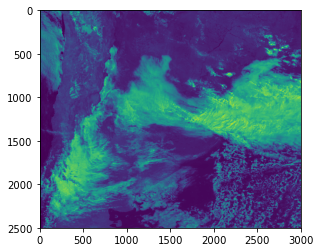

In [9]:
img1 = np.load('data/images/dia_277/ART_2020277_162019.npy')
img2 = np.load('data/images/dia_277/ART_2020277_163019.npy')
img3 = np.load('data/images/dia_91/ART_2020091_141021.npy')

plt.imshow(img1)
plt.show()

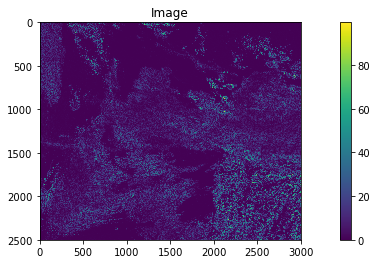

In [3]:
visualization.show_images_diff(img1,img2)

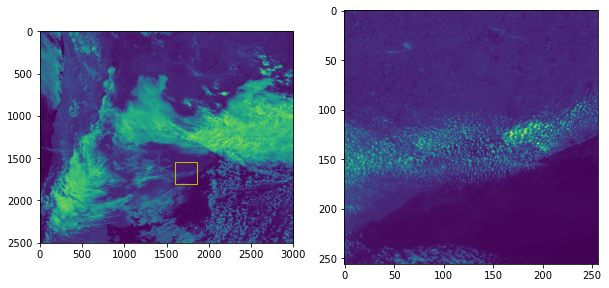

(2501, 3001)


In [17]:
fig, ax = plt.subplots(figsize=(10,10),ncols=2)
p,q = 1600,1550

rect4 = patches.Rectangle((p, q), 256, 256, linewidth=1, edgecolor='y', facecolor='none')
ax[0].add_patch(rect4)

ax[0].imshow(img1)
ax[1].imshow(img1[q:q+256,p:p+256])
plt.show()

print(img1.shape)

In [16]:
np.save(file='misc/montevideo1.npy' ,arr = img3[q:q+256,p:p+256])
